# IMPORTS

## Instalations

In [85]:
%pip install inflection
%pip install tabulate
%pip install boruta
%pip install scikit-plot

## Libraries

In [86]:
# colab configurations
from google.colab import drive

# data analytics
import pandas  as pd
import numpy   as np

# helper libraries
from IPython.core.display import HTML
from IPython.display      import Image
import requests
import json
import warnings
import pickle
from tabulate        import tabulate
import inflection

# graphs plot
import seaborn as sns
from matplotlib import pyplot as plt

# data preparation
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# feature selection
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model  import LinearRegression, Lasso
from boruta                import BorutaPy
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFE

# balancing data
from imblearn                import under_sampling as us
from imblearn                import over_sampling as os
from imblearn                import combine as c
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,RandomizedSearchCV

# machine learning
from sklearn.ensemble      import RandomForestClassifier,ExtraTreesClassifier,IsolationForest
from sklearn.linear_model  import SGDClassifier 
from lightgbm                import LGBMClassifier

#metrics
from sklearn.metrics         import accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve
from scikitplot              import metrics      as mt
from sklearn.calibration     import calibration_curve,CalibratedClassifierCV

#hyperparameter fine tuning
import random
import warnings

# error interpretation
from sklearn.metrics       import mean_absolute_error, mean_squared_error

# deploy model
from scipy           import stats as ss
from flask           import Flask

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [87]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0.1. Helper Functions

In [88]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [16, 12]
    plt.rcParams['font.size'] = 24

    sns.set()

In [89]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2. Loading Data

## 0.2.1. Initial Data

In [90]:
df_raw = pd.read_csv('/content/drive/My Drive/syn_finan/fraud_detect/data/fraud_test_det.csv')

## 0.2.2. Droping Unnamed Column

In [91]:
df_raw = df_raw.drop('Unnamed: 0', axis=1)

In [92]:
df_raw.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'date'],
      dtype='object')

# 1.0. Step 01 - Data Descriptions

## 1.1. Rename Columns

In [93]:
df1 = df_raw.copy()

In [94]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'date'],
      dtype='object')

In [95]:
cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'date']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [96]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud', 'date'],
      dtype='object')

## 1.2. Data Dimensions

In [97]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1008213
Number of Cols: 12


## 1.3. Data Types

In [98]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
date                 object
dtype: object

## 1.4. Check NA

In [99]:
df1.isna().sum()

step                    0
type                    0
amount                  0
name_orig               0
oldbalance_org          0
newbalance_orig         0
name_dest               0
oldbalance_dest         0
newbalance_dest         0
is_fraud                0
is_flagged_fraud        0
date                13314
dtype: int64

In [100]:
df1[df1['date'] == 'NaT']

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,date


## 1.5. Fillout NA

In [101]:
#for i in range(len(df1)):
#   if df1.loc[i, 'date'] == 'NaT':
#    df1.loc[i, 'date'] = df1.loc[i-1, 'date']

In [102]:
#pickle.dump(df1, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/df1_na.pkl', 'wb'))
df1 = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/df1_na.pkl', 'rb'))

In [103]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
date                0
dtype: int64

## 1.6. Changing Dtypes

In [104]:
df1['date'] = pd.to_datetime(df1['date'])

In [105]:
df1.dtypes

step                         int64
type                        object
amount                     float64
name_orig                   object
oldbalance_org             float64
newbalance_orig            float64
name_dest                   object
oldbalance_dest            float64
newbalance_dest            float64
is_fraud                     int64
is_flagged_fraud             int64
date                datetime64[ns]
dtype: object

## 1.7. Descriptive Statistical

In [106]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

In [107]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, knew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate

m = pd.concat([ct1, ct2, d1, d2, d3, d4, d5, d6]).T.reset_index()
m.columns = ['attributes', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
m

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,step,245.35071,249.00000,144.41473,1.00000,743.00000,742.00000,0.41556,0.36681
1,amount,188715.00408,76320.65000,636031.70145,0.00000,64234448.19000,64234448.19000,26.05246,1283.04048
2,oldbalance_org,843482.50939,14818.00000,2902988.50021,0.00000,59585040.37000,59585040.37000,5.25387,33.31737
3,newbalance_orig,854657.17532,0.00000,2928073.25318,0.00000,49585040.37000,49585040.37000,5.19308,32.32773
4,oldbalance_dest,1098601.73474,130575.14000,3399759.86495,0.00000,355185537.06000,355185537.06000,20.39176,1011.63128
5,newbalance_dest,1226703.55511,215259.59000,3660140.00930,0.00000,355380483.53000,355380483.53000,19.30120,874.63438
6,is_fraud,0.00815,0.00000,0.08989,0.00000,1.00000,1.00000,10.94380,117.76699
7,is_flagged_fraud,0.00002,0.00000,0.00398,0.00000,1.00000,1.00000,251.01892,63008.62500


## 1.8. Checking Outliers

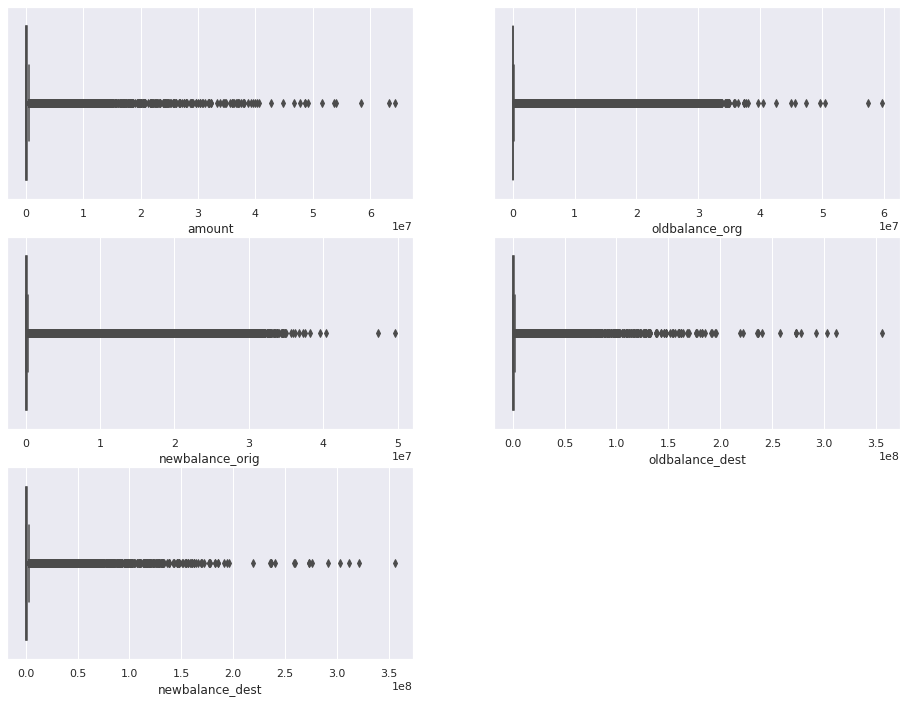

In [108]:
#amount
plt.subplot(3,2,1)
sns.boxplot(df1['amount']);

#oldbalance_org
plt.subplot(3,2,2)
sns.boxplot(df1['oldbalance_org']);

#newbalance_org
plt.subplot(3,2,3)
sns.boxplot(df1['newbalance_orig']);

#oldbalance_dest
plt.subplot(3,2,4)
sns.boxplot(df1['oldbalance_dest']);

#newbalance_dest
plt.subplot(3,2,5)
sns.boxplot(df1['newbalance_dest']);

## 1.7. Checking Distribution

In [109]:
num_attributes.head()

,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,1,181.00000,181.00000,0.00000,0.00000,0.00000,1,0
1,310,962.43000,26770.94000,25808.50000,0.00000,0.00000,0,0
2,162,6688.74000,9207.00000,2518.26000,0.00000,0.00000,0,0
3,42,128487.35000,0.00000,0.00000,701404.75000,1567434.81000,0,0
4,235,83845.22000,10538.00000,0.00000,0.00000,83845.22000,0,0


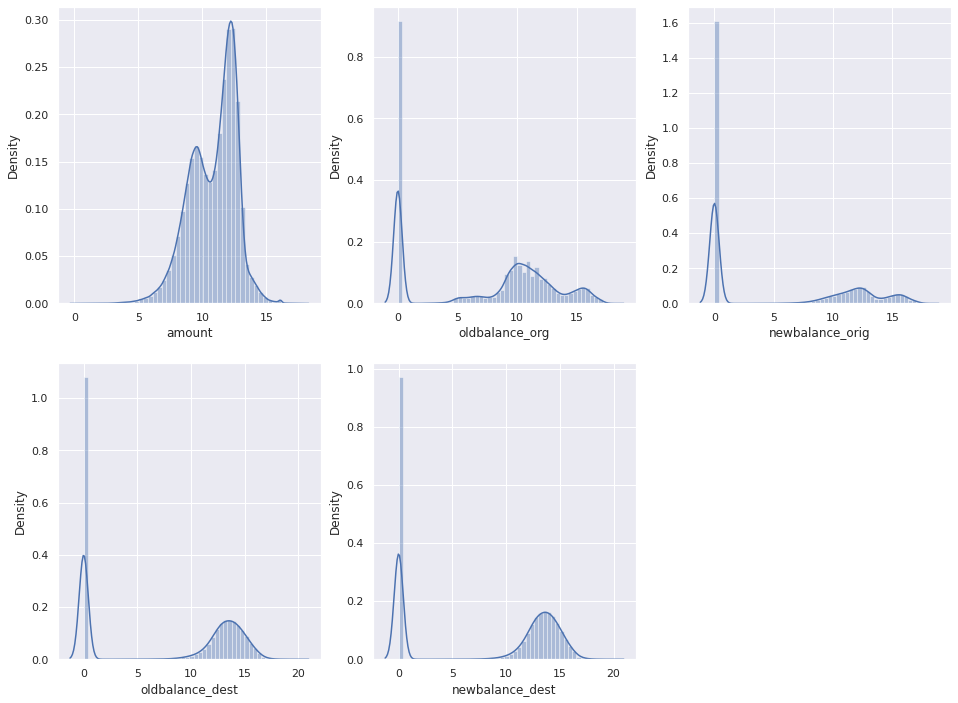

In [110]:
# Normal Distribution Check

# Amount
plt.subplot(2,3,1)
sns.distplot(np.log1p(num_attributes['amount']));

# Old Balance Origin
plt.subplot(2,3,2)
sns.distplot(np.log1p(num_attributes['oldbalance_org']));

# New Balance Origin
plt.subplot(2,3,3)
sns.distplot(np.log1p(num_attributes['newbalance_orig']));

# Old Balance Destiny
plt.subplot(2,3,4)
sns.distplot(np.log1p(num_attributes['oldbalance_dest']));

# New Balance Destiny
plt.subplot(2,3,5)
sns.distplot(np.log1p(num_attributes['newbalance_dest']));

## 1.9. Cattegorical Attributes

In [111]:
cat_attributes.apply(lambda x: x.unique().shape[0])

type               5
name_orig    1008002
name_dest     651556
date             690
dtype: int64

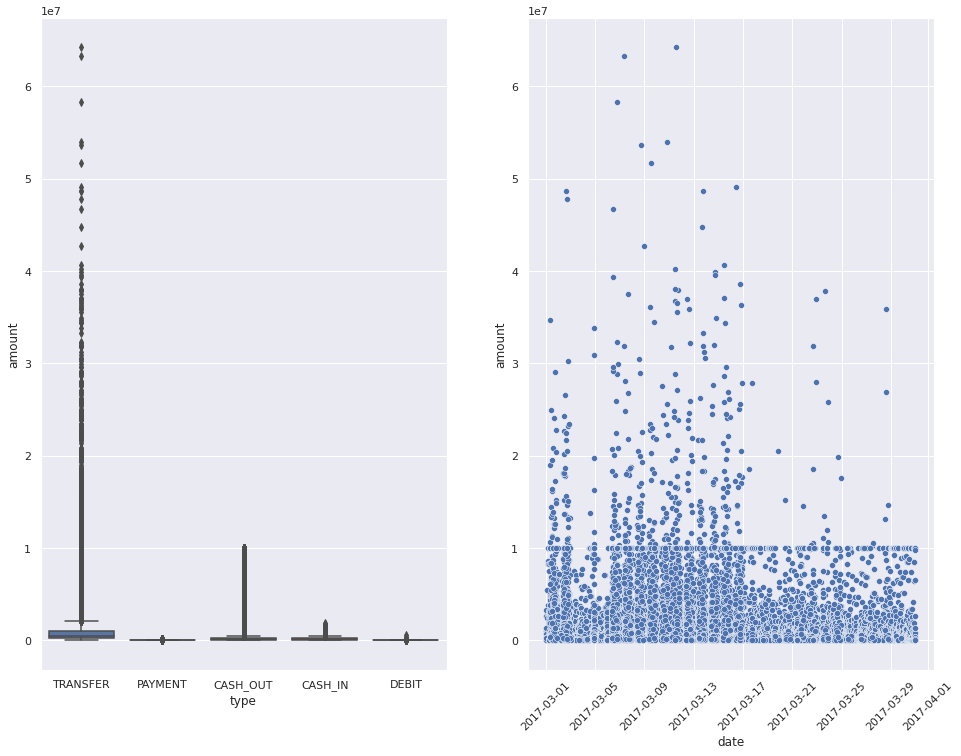

In [112]:
# Checking Outliers By Type
plt.subplot(1, 2, 1)
sns.boxplot(x='type', y='amount', data=df1)

# Checking Outliers By Date
plt.subplot(1, 2, 2)
sns.scatterplot(x='date', y='amount', data=df1);
plt.xticks(rotation=45);

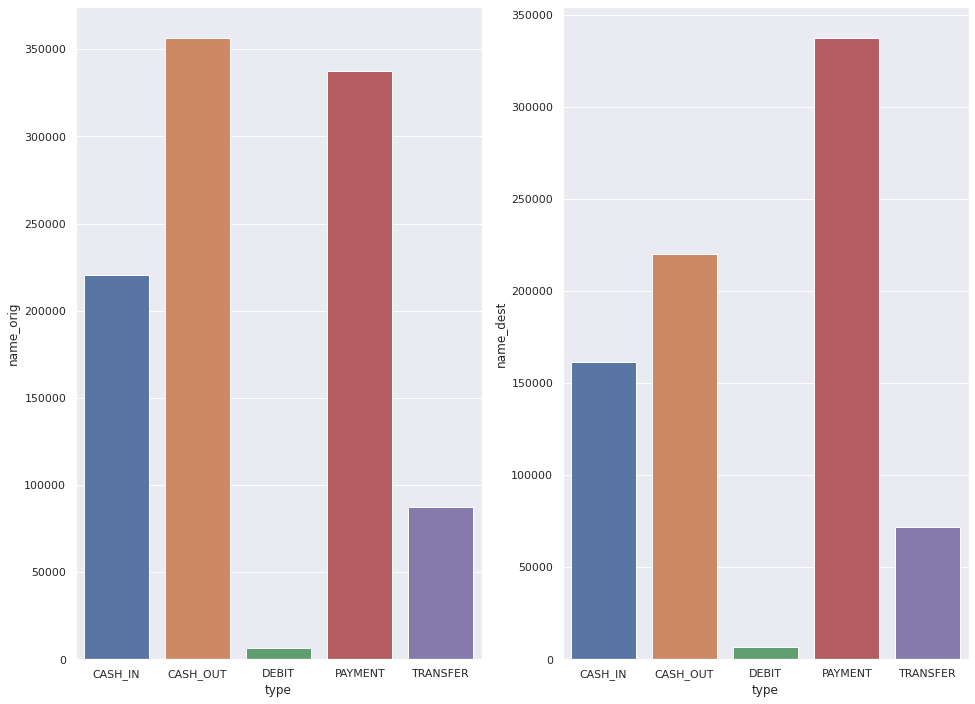

In [113]:
# Checking Quantity of Customers Origin By Type
df1_norig = df1[['type', 'name_orig']].groupby('type').nunique().reset_index()
plt.subplot(1, 2, 1)
sns.barplot(x='type', y='name_orig', data=df1_norig);

# Checking Quantity of Customers Destiny By Type
df1_nodest = df1[['type', 'name_dest']].groupby('type').nunique().reset_index()
plt.subplot(1, 2, 2)
sns.barplot(x='type', y='name_dest', data=df1_nodest);

# 2.0. Step 02 - Feature Engineering

In [114]:
df2 = df1.copy()

## 2.1. Mindmap

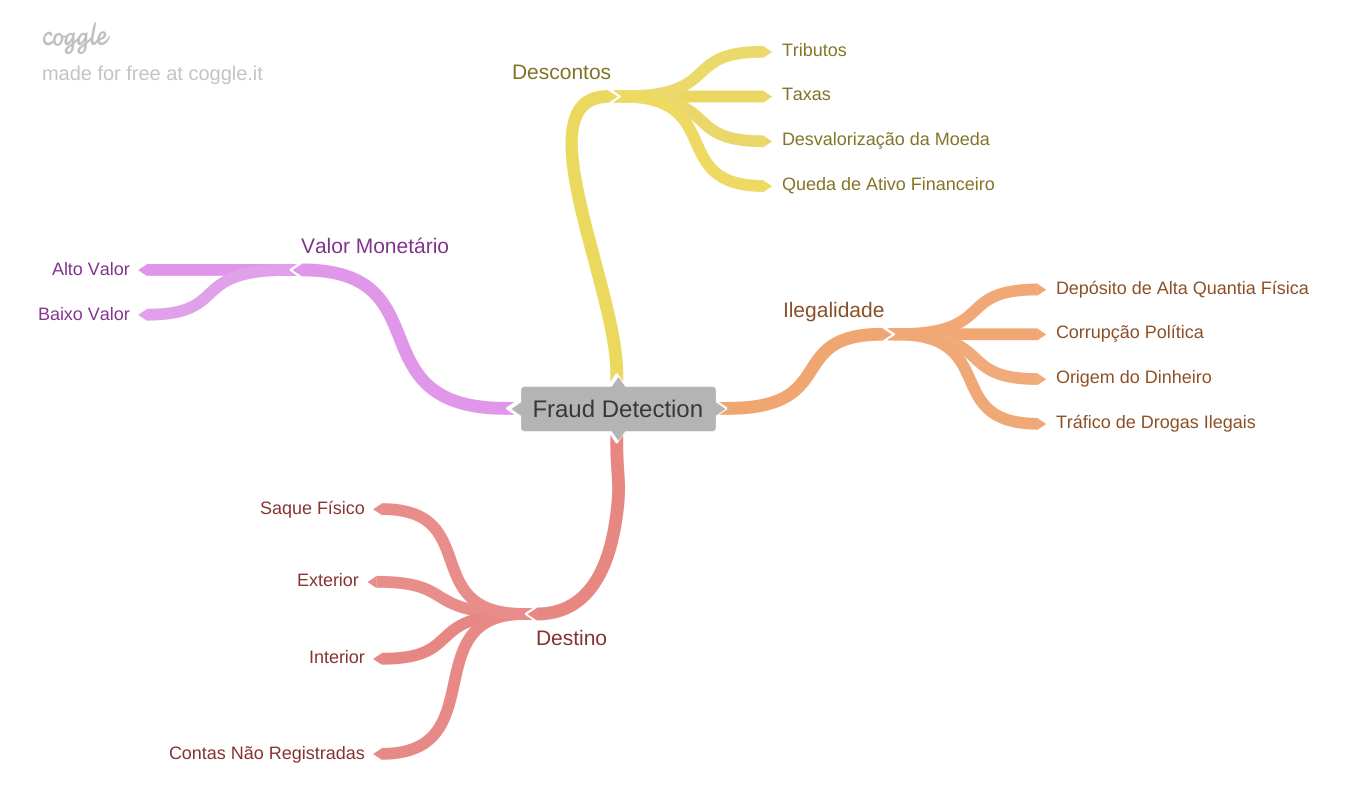

In [115]:
Image('/content/drive/My Drive/syn_finan/image/fraud_detection.png')

## 2.2. Hypothesis List

**H1.** Transactions on the weekends has more chance to be fraud.

**H2.** The first two weeks of the months has more chances to be fraud.

**H3.** On dawns transactions has more chance to be a fraud.

**H4.** Transactions amounts more than $ 200,000.00 has more chances to be fraud.

**H5.** The type of transactions influences in the chances of be fraud.

**H6.** Transactions with origim accounts with zero values in the initial time has more chances to be fraud.

**H7.** Transaction with origim accounts with zero values in the final time has more chcances to be fraud.

**H8.** Transactions with destiny accounts with zero values in the initial time has more chances to be fraud.

**H9.** Transaction with destiny accounts with zero values in the final time has more chances to be fraud.

## 2.4. Feature Engineering

In [116]:
# hour of day
df2['hour_of_day'] = df2['date'].dt.strftime('%H')
df2['hour_of_day'] = df2['hour_of_day'].astype(int64)

# days of Week
df2['day_of_week'] = df2['date'].dt.dayofweek # Monday = 0, Sunday = 6.
 
# Weeks of Year
df2['week_of_year'] = df2['date'].dt.isocalendar().week # First Week = 9, Last Week = 13

# customer Types
df2['client_orig'] = df2['name_orig'].apply(lambda x: 1 if 'M' in x else 0)
df2['client_dest'] = df2['name_dest'].apply(lambda x: 1 if 'M' in x else 0)

# transaction type
# 0 - Transfer, 1 - Payment, 2 - Cash_Out, 3 - Cash_In, 4 - Debit.
df2['encoded_type'] = df2['type'].apply(lambda x: 0 if (x == 'TRANSFER') else 1 if (x == 'PAYMENT') else 2 if (x == 'CASH_OUT') else 3 if (x == 'CASH_IN') else 4)

# Zero or Not
df2['zero_new_orig'] = df2['newbalance_orig'].apply(lambda x: 1 if x == 0 else 0)
df2['zero_old_orig'] = df2['oldbalance_org'].apply(lambda x: 1 if x == 0 else 0)
df2['zero_new_dest'] = df2['newbalance_dest'].apply(lambda x: 1 if x == 0 else 0)
df2['zero_old_dest'] = df2['oldbalance_dest'].apply(lambda x: 1 if x == 0 else 0)

In [117]:
df2.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,date,hour_of_day,day_of_week,week_of_year,client_orig,client_dest,encoded_type,zero_new_orig,zero_old_orig,zero_new_dest,zero_old_dest
0,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1,0,2017-03-01 01:00:00,1,2,9,0,0,0,1,0,1,1
1,310,PAYMENT,962.43000,C1831141281,26770.94000,25808.50000,M1705277839,0.00000,0.00000,0,0,2017-03-12 22:00:00,22,6,10,0,1,1,0,0,1,1
2,162,PAYMENT,6688.74000,C1377301456,9207.00000,2518.26000,M938199512,0.00000,0.00000,0,0,2017-03-07 18:00:00,18,1,10,0,1,1,0,0,1,1
3,42,CASH_OUT,128487.35000,C50503805,0.00000,0.00000,C747464370,701404.75000,1567434.81000,0,0,2017-03-02 18:00:00,18,3,9,0,0,2,1,1,0,0
4,235,TRANSFER,83845.22000,C1386020581,10538.00000,0.00000,C990398217,0.00000,83845.22000,0,0,2017-03-10 19:00:00,19,4,10,0,0,0,1,0,0,1


# 3.0. Step 03 - Filtering Variables

In [118]:
df3 = df2.copy()

In [119]:
df3.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,date,hour_of_day,day_of_week,week_of_year,client_orig,client_dest,encoded_type,zero_new_orig,zero_old_orig,zero_new_dest,zero_old_dest
0,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1,0,2017-03-01 01:00:00,1,2,9,0,0,0,1,0,1,1
1,310,PAYMENT,962.43000,C1831141281,26770.94000,25808.50000,M1705277839,0.00000,0.00000,0,0,2017-03-12 22:00:00,22,6,10,0,1,1,0,0,1,1
2,162,PAYMENT,6688.74000,C1377301456,9207.00000,2518.26000,M938199512,0.00000,0.00000,0,0,2017-03-07 18:00:00,18,1,10,0,1,1,0,0,1,1
3,42,CASH_OUT,128487.35000,C50503805,0.00000,0.00000,C747464370,701404.75000,1567434.81000,0,0,2017-03-02 18:00:00,18,3,9,0,0,2,1,1,0,0
4,235,TRANSFER,83845.22000,C1386020581,10538.00000,0.00000,C990398217,0.00000,83845.22000,0,0,2017-03-10 19:00:00,19,4,10,0,0,0,1,0,0,1


## 3.1. Filtering Lines

In [120]:
df3 = df3[(df3['client_dest'] == 0) & (df3['type'] != 'CASH_IN') & (df3['type'] != 'DEBIT')]

## 3.2. Filtering Columns

In [121]:
# Excluding Explained Columns On Other Variables
df3 = df3.drop(['name_orig', 'name_dest', 'client_orig', 'client_dest', 'step', 'type'], axis=1)

In [122]:
df3.columns

Index(['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest',
       'newbalance_dest', 'is_fraud', 'is_flagged_fraud', 'date',
       'hour_of_day', 'day_of_week', 'week_of_year', 'encoded_type',
       'zero_new_orig', 'zero_old_orig', 'zero_new_dest', 'zero_old_dest'],
      dtype='object')

# 4.0. Step 04 - Exploratoring Analysis of Data

In [123]:
df4 = df3.copy()

## 4.1. Univariable Analysis

### 4.1.1. Numerical Variable

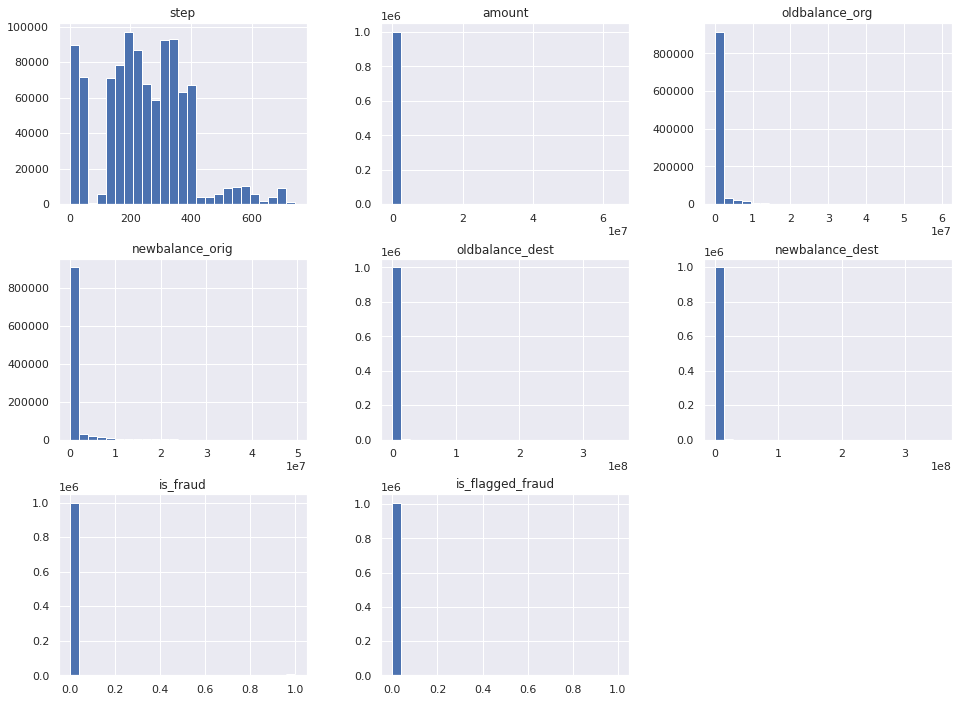

In [124]:
num_attributes.hist(bins=25);

## 4.2. Bivariable Analysis

### **H1.** Transactions on the weekends has more chance to be fraud. (True)

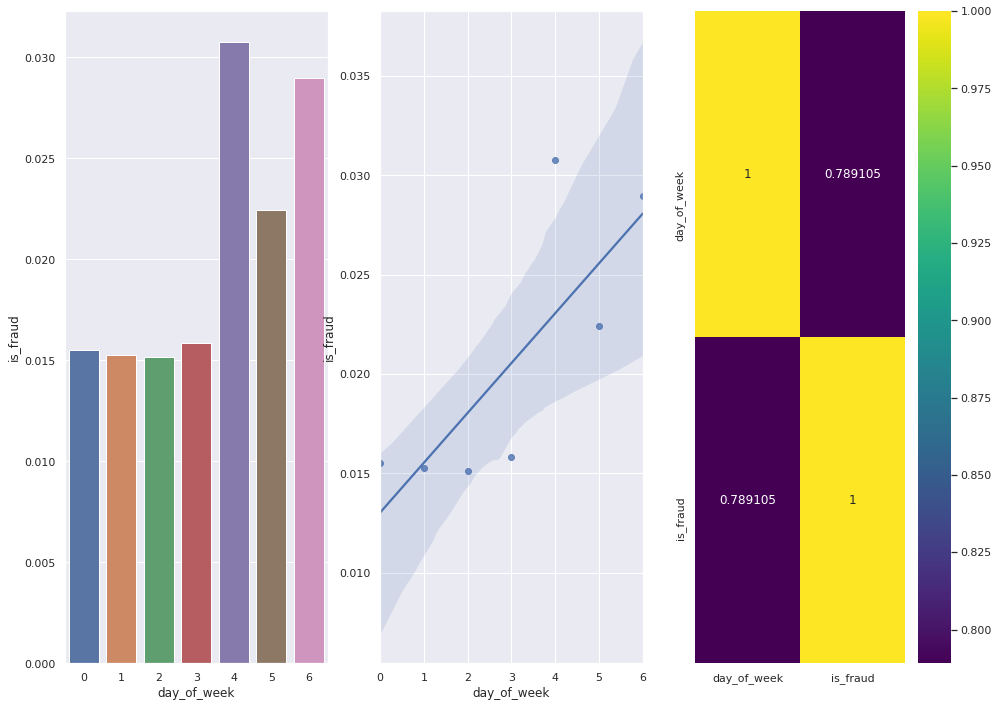

In [125]:
plt.subplot(1, 3, 1)
aux1 = df4[['day_of_week', 'is_fraud']].groupby('day_of_week').mean().reset_index()
sns.barplot(x='day_of_week', y='is_fraud', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='is_fraud', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

### **H2.** The first two weeks of the months has more chances to be fraud. (False - Insight)

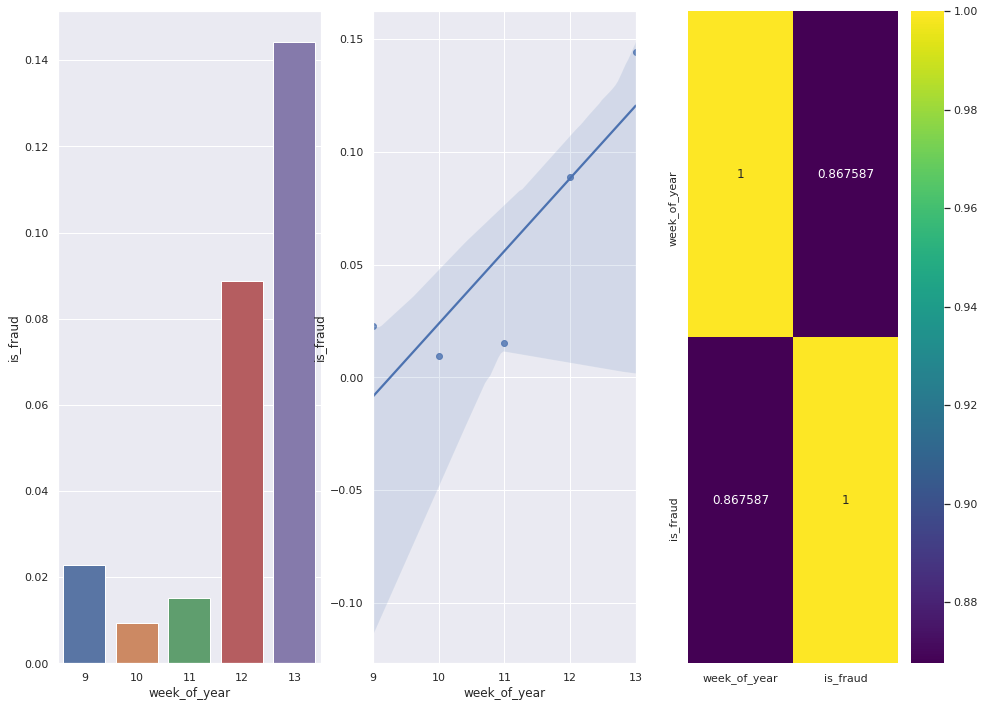

In [126]:
plt.subplot(1, 3, 1)
aux1 = df4[['week_of_year', 'is_fraud']].groupby('week_of_year').mean().reset_index()
sns.barplot(x='week_of_year', y='is_fraud', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='week_of_year', y='is_fraud', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt="g", cmap='viridis');

### **H3.** On dawns transactions has more chance to be a fraud. (True)

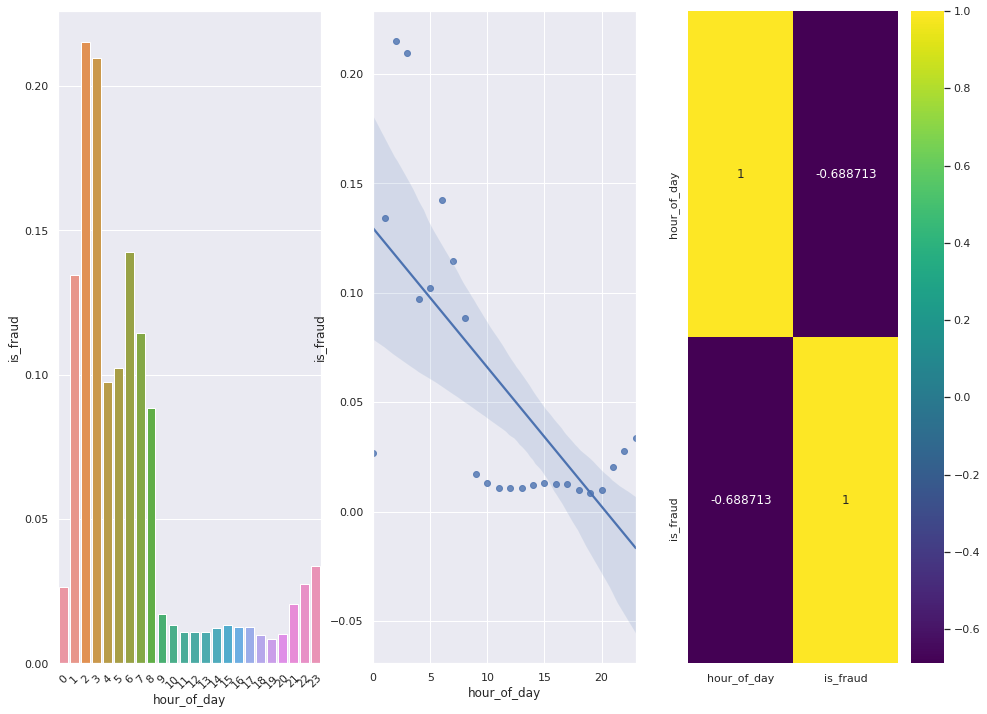

In [127]:
plt.subplot(1, 3, 1)
aux1 = df4[['hour_of_day', 'is_fraud']].groupby('hour_of_day').mean().reset_index()
sns.barplot(x='hour_of_day', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.regplot(x='hour_of_day', y='is_fraud', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True, fmt="g", cmap='viridis');

### **H4.** Transactions amounts more than $ 200,000.00 has more chances to be fraud. (True)

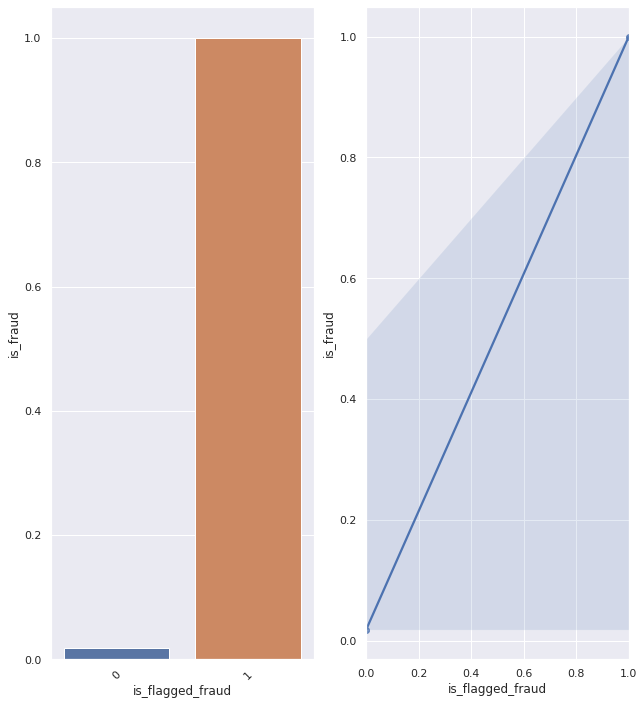

In [128]:
plt.subplot(1, 3, 1)
aux1 = df4[['is_flagged_fraud', 'is_fraud']].groupby('is_flagged_fraud').mean().reset_index()
sns.barplot(x='is_flagged_fraud', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.regplot(x='is_flagged_fraud', y='is_fraud', data=aux1);

### **H5.** Cash out transactions has more chances to be fraud. (False - Insight)

In [129]:
# 0 - Transfer, 2 - Cash_Out.

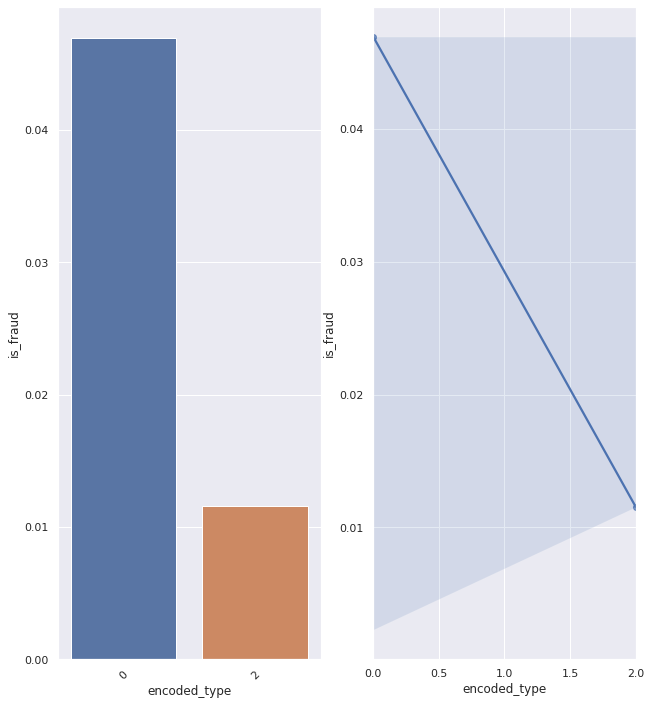

In [130]:
plt.subplot(1, 3, 1)
aux1 = df4[['encoded_type', 'is_fraud']].groupby('encoded_type').mean().reset_index()
sns.barplot(x='encoded_type', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.regplot(x='encoded_type', y='is_fraud', data=aux1);

### **H6.** Transactions with origim accounts with zero values in the initial time has more chances to be fraud. (False - Insight)

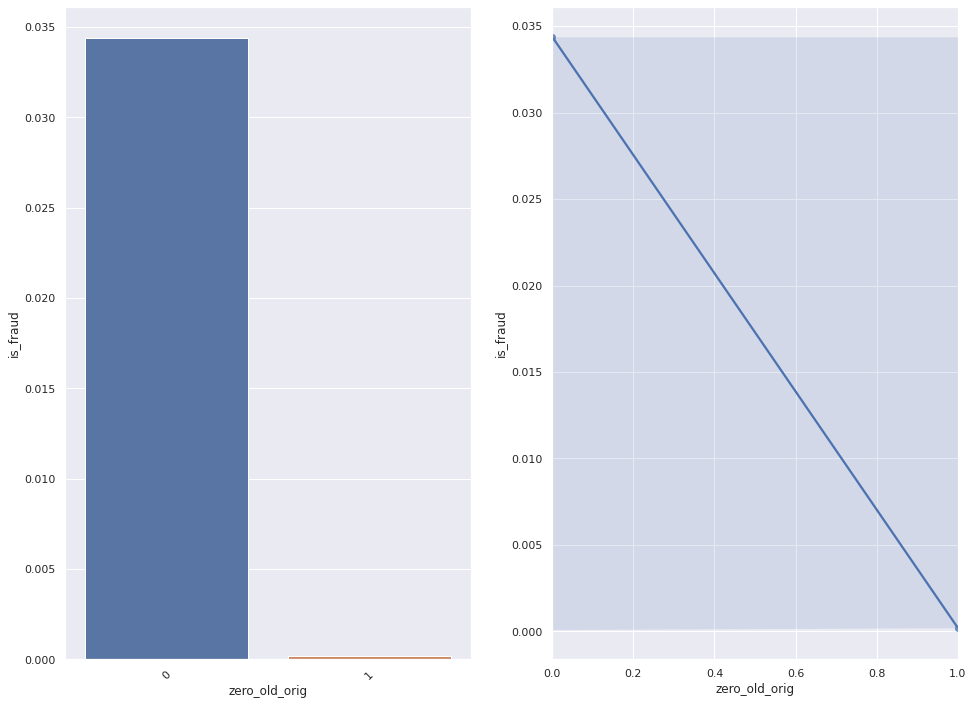

In [131]:
plt.subplot(1, 2, 1)
aux1 = df4[['zero_old_orig', 'is_fraud']].groupby('zero_old_orig').mean().reset_index()
sns.barplot(x='zero_old_orig', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.regplot(x='zero_old_orig', y='is_fraud', data=aux1);

### **H7.** Transactions with origim accounts with zero values in the final time has more chances to be fraud. (False)

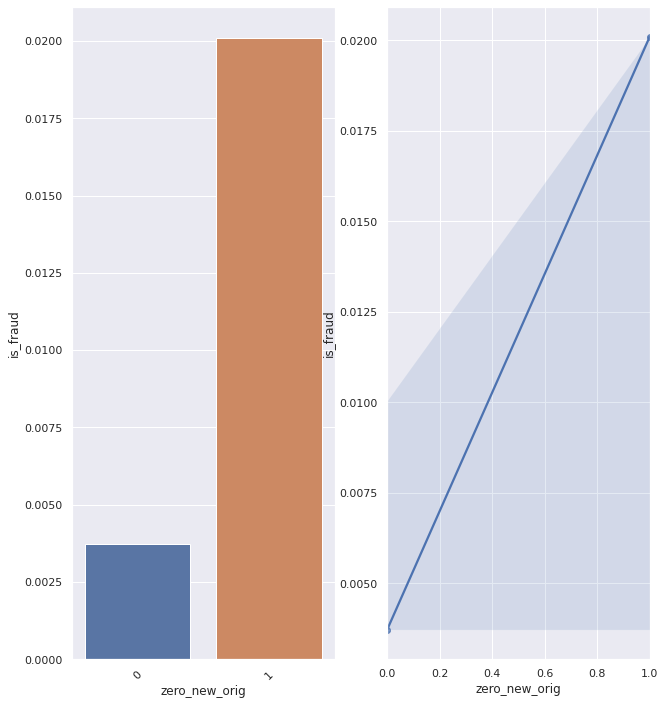

In [132]:
plt.subplot(1, 3, 1)
aux1 = df4[['zero_new_orig', 'is_fraud']].groupby('zero_new_orig').mean().reset_index()
sns.barplot(x='zero_new_orig', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.regplot(x='zero_new_orig', y='is_fraud', data=aux1);

### **H8.** Transactions with destiny accounts with zero values in the initial time has more chances to be fraud. (True)

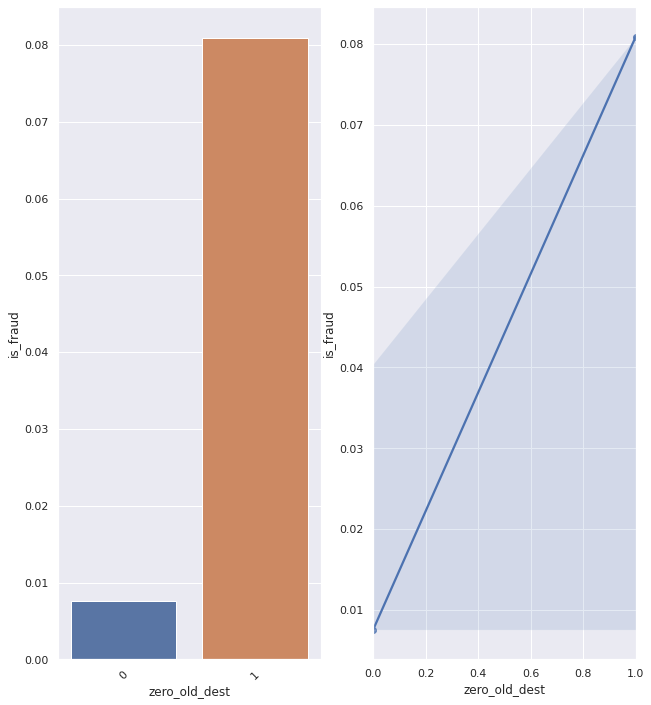

In [133]:
plt.subplot(1, 3, 1)
aux1 = df4[['zero_old_dest', 'is_fraud']].groupby('zero_old_dest').mean().reset_index()
sns.barplot(x='zero_old_dest', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.regplot(x='zero_old_dest', y='is_fraud', data=aux1);

### **H9.** Transaction with destiny accounts with zero values in the final time has more chances to be fraud. (True)

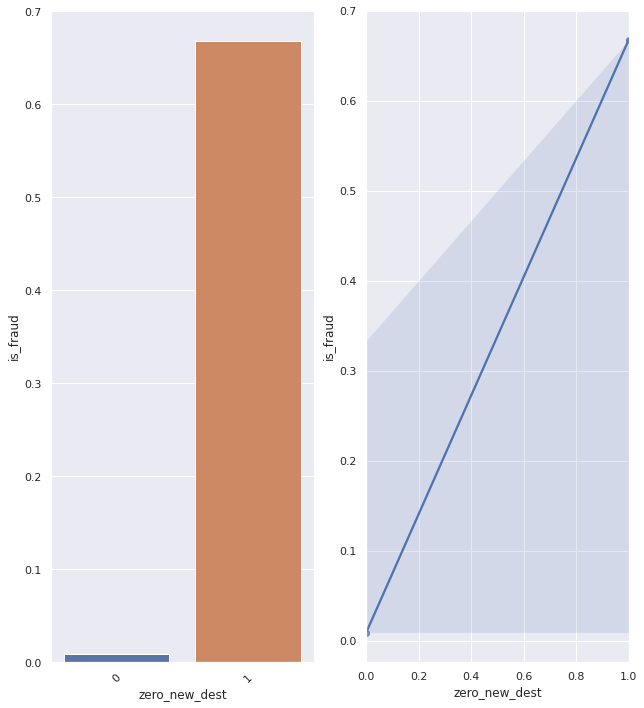

In [134]:
plt.subplot(1, 3, 1)
aux1 = df4[['zero_new_dest', 'is_fraud']].groupby('zero_new_dest').mean().reset_index()
sns.barplot(x='zero_new_dest', y='is_fraud', data=aux1)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.regplot(x='zero_new_dest', y='is_fraud', data=aux1);

### 4.2.1. Hypothesis Sumary

In [135]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'High'],
       ['H2', 'False', 'High'],
       ['H3', 'True', 'High'],
       ['H4', 'True', 'High'],
       ['H5', 'False', 'High'],
       ['H6', 'False', 'High'],
       ['H7', 'True', 'High'],
       ['H8', 'True', 'High'],
       ['H9', 'True', 'High']]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            True          High
H2            False         High
H3            True          High
H4            True          High
H5            False         High
H6            False         High
H7            True          High
H8            True          High
H9            True          High


## 4.2. Multivariable Analysis

### 4.2.1. Correlations

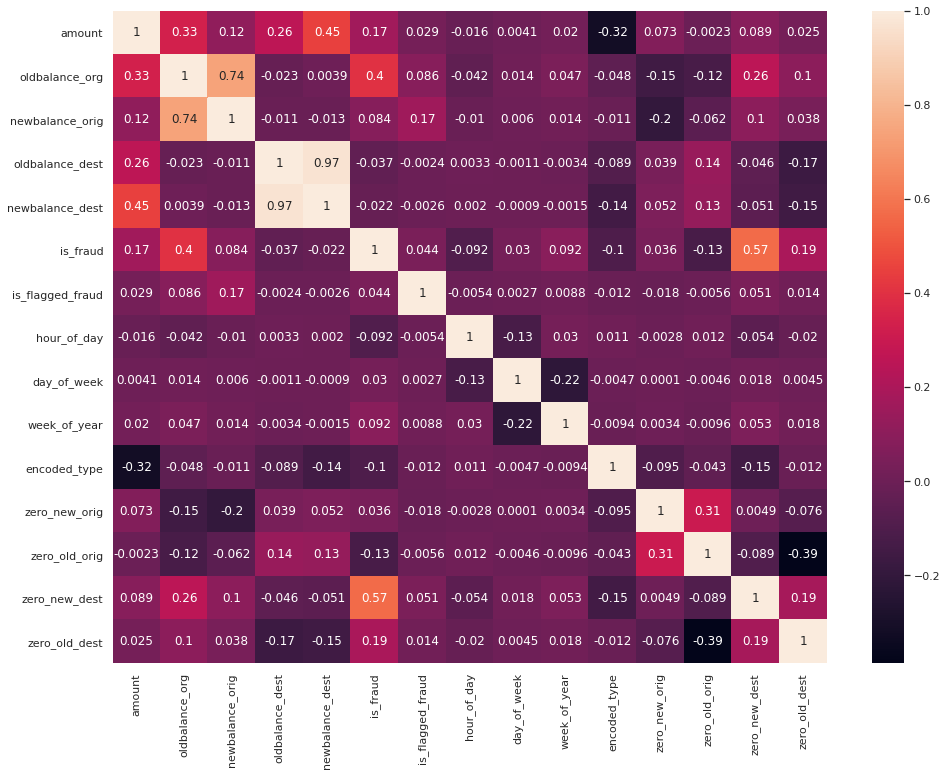

In [136]:
correlation = df4.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# 5.0. Step 05 - Data Preparation

In [137]:
df5 = df4.copy()

## 5.1. Rescaling

In [138]:
df5.head()

,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,date,hour_of_day,day_of_week,week_of_year,encoded_type,zero_new_orig,zero_old_orig,zero_new_dest,zero_old_dest
0,181.00000,181.00000,0.00000,0.00000,0.00000,1,0,2017-03-01 01:00:00,1,2,9,0,1,0,1,1
3,128487.35000,0.00000,0.00000,701404.75000,1567434.81000,0,0,2017-03-02 18:00:00,18,3,9,2,1,1,0,0
4,83845.22000,10538.00000,0.00000,0.00000,83845.22000,0,0,2017-03-10 19:00:00,19,4,10,0,1,0,0,1
6,345858.07000,21523.00000,0.00000,0.00000,45881.29000,0,0,2017-03-13 15:00:00,15,0,11,0,1,0,0,1
8,98247.27000,107181.00000,8933.73000,0.00000,54985.05000,0,0,2017-03-02 10:00:00,10,3,9,2,0,0,0,1


In [139]:
a = df5.select_dtypes(include=['int64', 'float64'])

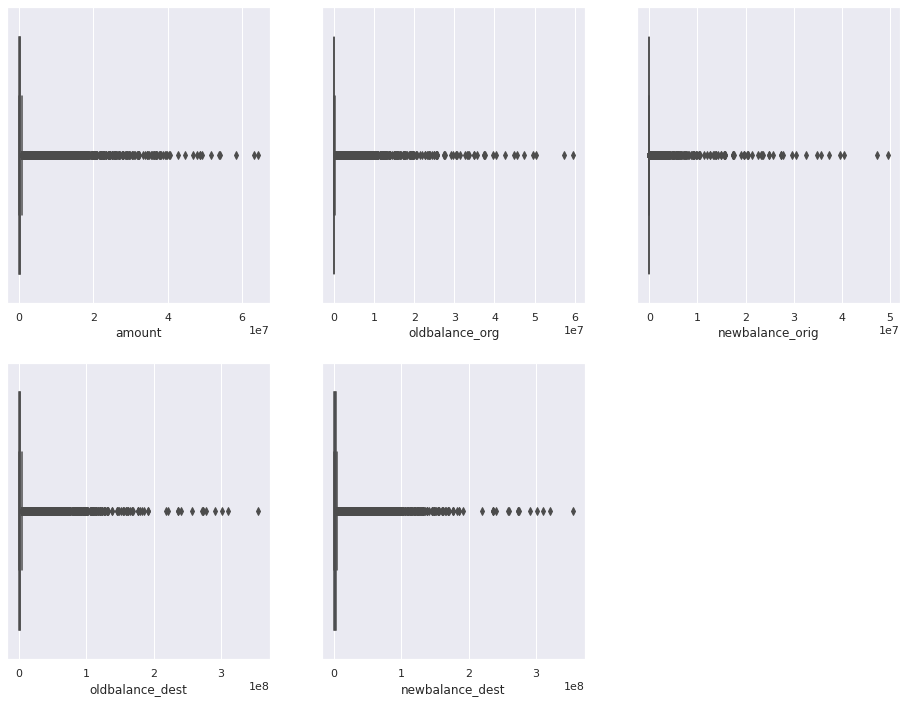

In [140]:
# amount
plt.subplot(2, 3, 1)
sns.boxplot(df5['amount']);

# oldbalance_org
plt.subplot(2, 3, 2)
sns.boxplot(df5['oldbalance_org']);

# newbalance_orig
plt.subplot(2, 3, 3)
sns.boxplot(df5['newbalance_orig']);

# oldbalance_dest
plt.subplot(2, 3, 4)
sns.boxplot(df5['oldbalance_dest']);

# newbalance_dest
plt.subplot(2, 3, 5)
sns.boxplot(df5['newbalance_dest']);

In [141]:
rs = RobustScaler()

# amount
df5['amount'] = rs.fit_transform( df5[['amount']].values )
pickle.dump(rs, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/amount_parameter.pkl', 'wb'))
#df5['amount'] = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/amount_parameter.pkl', 'rb'))

# oldbalance_org
df5['oldbalance_org'] = rs.fit_transform( df5[['oldbalance_org']].values )
pickle.dump(rs, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/oldbalance_org_parameter', 'wb'))
#df5['oldbalance_org'] = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/oldbalance_org_parameter', 'rb'))

# newbalance_orig
df5['newbalance_orig'] = rs.fit_transform( df5[['newbalance_orig']].values )
pickle.dump(rs, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/newbalance_orig_parameter.pkl', 'wb'))
#df5['newbalance_orig'] = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/newbalance_orig_parameter.pkl', 'rb'))

# oldbalance_dest
df5['oldbalance_dest'] = rs.fit_transform( df5[['oldbalance_dest']].values )
pickle.dump(rs, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/oldbalance_dest_parameter', 'wb'))
#df5['oldbalance_dest'] = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/oldbalance_dest_parameter', 'rb'))

# newbalance_dest
df5['newbalance_dest'] = rs.fit_transform( df5[['newbalance_dest']].values )
pickle.dump(rs, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/newbalance_dest_parameter.pkl', 'wb'))
#df5['newbalance_dest'] = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/newbalance_dest_parameter.pkl', 'rb'))

In [142]:
df5.head()

,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,date,hour_of_day,day_of_week,week_of_year,encoded_type,zero_new_orig,zero_old_orig,zero_new_dest,zero_old_dest
0,-0.75708,-0.00893,0.00000,-0.34101,-0.45830,1,0,2017-03-01 01:00:00,1,2,9,0,1,0,1,1
3,-0.19361,-0.01445,0.00000,0.09993,0.41958,0,0,2017-03-02 18:00:00,18,3,9,2,1,1,0,0
4,-0.38966,0.30683,0.00000,-0.34101,-0.41134,0,0,2017-03-10 19:00:00,19,4,10,0,1,0,0,1
6,0.76101,0.64174,0.00000,-0.34101,-0.43261,0,0,2017-03-13 15:00:00,15,0,11,0,1,0,0,1
8,-0.32641,3.25326,8933.73000,-0.34101,-0.42751,0,0,2017-03-02 10:00:00,10,3,9,2,0,0,0,1


## 5.2. Transformation

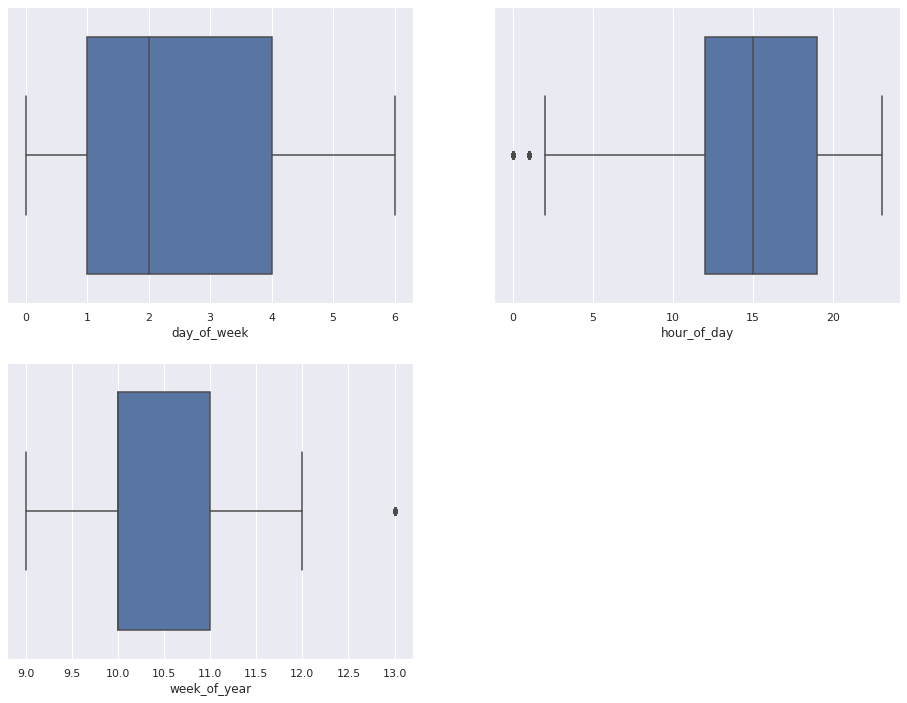

In [143]:
# day_of_week
plt.subplot(2, 2, 1)
sns.boxplot(df5['day_of_week']);

# hour_of_day
plt.subplot(2, 2, 2)
sns.boxplot(df5['hour_of_day']);

# week_of_year
plt.subplot(2, 2, 3)
sns.boxplot(df5['week_of_year']);

In [144]:
mms = MinMaxScaler()

# day_of_week
df5['day_of_week'] = mms.fit_transform( df5[['day_of_week']].values )
pickle.dump(mms, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/day_of_week_parameter.pkl', 'wb'))
#df5['day_of_week'] = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/day_of_week_parameter.pkl', 'rb'))

# hour_of_day
df5['hour_of_day'] = mms.fit_transform( df5[['hour_of_day']].values )
pickle.dump(mms, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/hour_of_day_parameter.pkl', 'wb'))
#df5['hour_of_day'] = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/newbalance_dest_parameter.pkl', 'rb'))

# week_of_year
df5['week_of_year'] = mms.fit_transform( df5[['week_of_year']].values )
pickle.dump(mms, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/week_of_year_parameter.pkl', 'wb'))
#df5['newbalance_orig'] = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/week_of_year_parameter.pkl', 'rb'))

# 6.0. Step 06 - Feature Selection

In [145]:
df6 = df5.drop('date', axis=1).copy()

In [146]:
X = df6.drop(columns = 'is_fraud', axis = 1)
Y = df6['is_fraud']

## 6.0.1. Manual Selected

In [147]:
manual = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest',
       'newbalance_dest', 'is_flagged_fraud', 'hour_of_day',
       'day_of_week', 'week_of_year', 'encoded_type', 'zero_new_orig',
       'zero_old_orig', 'zero_new_dest', 'zero_old_dest']

## 6.1. Recursive Feature Elimination (RFE)

In [148]:
#define model
#rf = RandomForestClassifier(n_jobs = -1)

#feature selector
#selector = RFE(rf, n_features_to_select = 7, step = 1)
#selector = selector.fit(X,Y)

#get ranking
#selector.support_

#pickle.dump(selector, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/selector_parameter.pkl', 'wb'))
selector = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/selector_parameter.pkl', 'rb'))

In [149]:
rfe_selected = X.loc[:, selector.support_]
rfe_selected.columns

Index(['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest',
       'newbalance_dest', 'encoded_type', 'zero_new_dest'],
      dtype='object')

## 6.2. Boruta as a Feature Selector

In [150]:
#define model
#extra_model = ExtraTreesClassifier(n_jobs=-1)

#split data 
#X_train_nn = X.values
#y_train_nn = y.values.ravel()

#define boruta
#boruta = BorutaPy(extra_model, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_nn, y_train_nn)
#pickle.dump(boruta, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/boruta_parameter.pkl', 'wb'))
boruta = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/boruta_parameter.pkl', 'rb'))

#best features from boruta
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['amount',
 'oldbalance_org',
 'newbalance_dest',
 'hour_of_day',
 'day_of_week',
 'week_of_year',
 'encoded_type',
 'zero_new_dest',
 'zero_old_dest']

## 6.3. Cols Final

In [151]:
# columns selected
cols_final = ['amount',
 'oldbalance_org',
 'newbalance_dest',
 'hour_of_day',
 'day_of_week',
 'week_of_year',
 'encoded_type',
 'zero_new_dest',
 'zero_old_dest',
 'is_flagged_fraud',
 'zero_new_dest']

# columns to add
feat_to_add = ['is_fraud']

# 7.0. Step 07 - Machine Learning Modeling

In [152]:
df7 = df6.copy()

## 7.1. Derivating Data

In [153]:
#target variable and features split 
X = df7.drop(columns = 'is_fraud',axis = 1)
y = df7['is_fraud']

#train test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## 7.2. LGBMClassifier + Cross Validation

In [154]:
#define model
#lgbm = LGBMClassifier(n_jobs = -1)

#train_model
#lgbm.fit(X_train.values, y_train.values)
#pickle.dump(lgbm, open('/content/drive/My Drive/syn_finan/fraud_detect/models/lgbm.pkl', 'wb'))
lgbm = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/models/lgbm.pkl', 'rb'))

#predict model
#yhat_lgbm = lgbm.predict(X_test)
#pickle.dump(yhat_lgbm, open('/content/drive/My Drive/syn_finan/fraud_detect/models/yhat_lgbm.pkl', 'wb'))
yhat_lgbm = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/models/yhat_lgbm.pkl', 'rb'))

#performance
result_lgbm = pd.DataFrame(["LGBM Classifier",accuracy_score(y_test,yhat_lgbm),cohen_kappa_score(y_test,yhat_lgbm),
                          recall_score(y_test,yhat_lgbm), f1_score(y_test,yhat_lgbm),
                           precision_score(y_test,yhat_lgbm)]).T
result_lgbm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_lgbm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130637
           1       0.94      0.91      0.93      2456

    accuracy                           1.00    133093
   macro avg       0.97      0.95      0.96    133093
weighted avg       1.00      1.00      1.00    133093



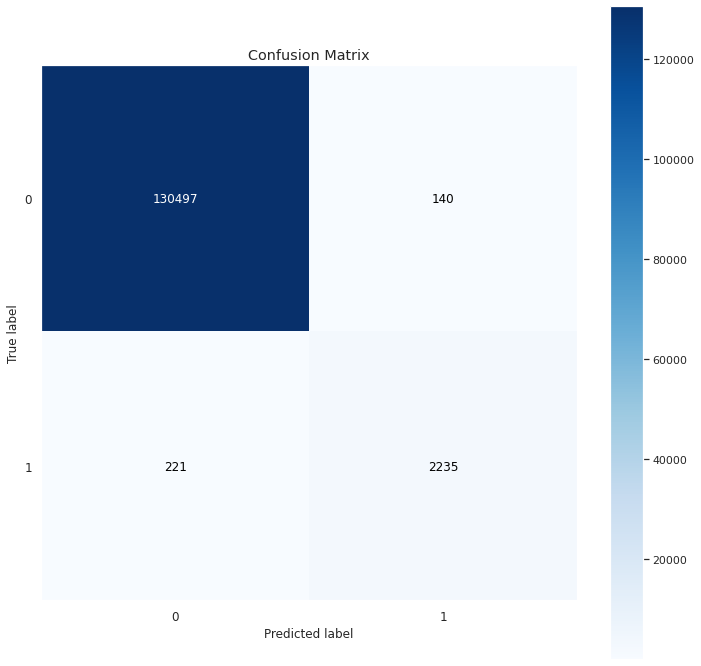

In [155]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_lgbm, normalize = False, figsize = (12,12))

## 7.2.1. Cross Validation LGBM

In [156]:
#cross validation scores
#lgbm_cv = cross_val_score(lgbm,X_train, y_train.ravel(), cv = 10, n_jobs = -1)
#pickle.dump(lgbm_cv, open('/content/drive/My Drive/syn_finan/fraud_detect/models/lgbm_cv.pkl', 'wb'))
lgbm_cv = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/models/lgbm_cv.pkl', 'rb'))

In [157]:
#mean and standard deviation
lgbm_true = "Average LGBM: {} +/- Std {}".format(np.round(np.mean(lgbm_cv),4),np.round(np.std(lgbm_cv),6))

## 7.3. RandomForestClassifier


In [158]:
#define model
#rf = RandomForestClassifier(n_jobs = -1)

#training model
#rf.fit(X_train, y_train)
#pickle.dump(rf, open('/content/drive/My Drive/syn_finan/fraud_detect/models/rf.pkl', 'wb'))
rf = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/models/rf.pkl', 'rb'))

#predict model
yhat_rf = rf.predict(X_test)
pickle.dump(yhat_rf, open('/content/drive/My Drive/syn_finan/fraud_detect/models/yhat_rf.pkl', 'wb'))
#yhat_rf = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/models/yhat_rf.pkl', 'rb'))

#performance
result_rf = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf),cohen_kappa_score(y_test,yhat_rf),
                          recall_score(y_test,yhat_rf), f1_score(y_test,yhat_rf),
                           precision_score(y_test,yhat_rf)]).T
result_rf.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130637
           1       0.98      0.82      0.89      2456

    accuracy                           1.00    133093
   macro avg       0.99      0.91      0.95    133093
weighted avg       1.00      1.00      1.00    133093



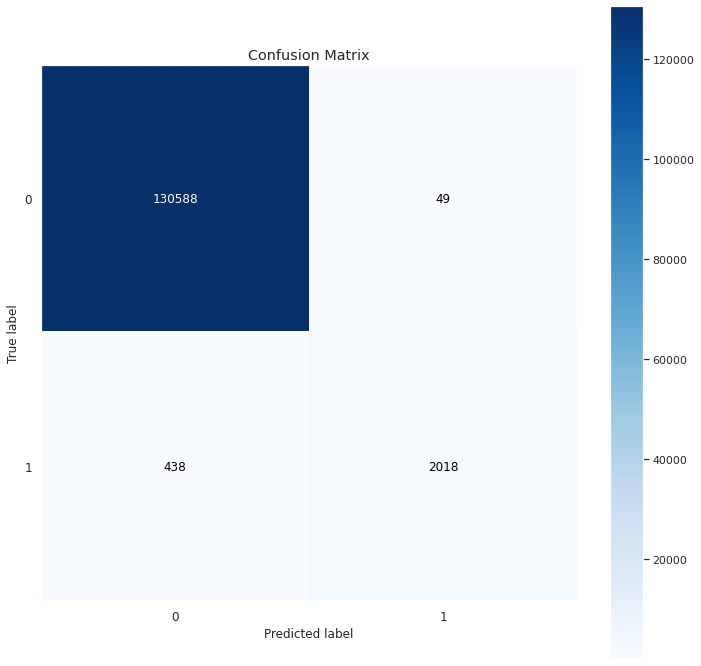

In [159]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_rf, normalize = False, figsize = (12,12))

## 7.3.1. Cross Validation Random Forest

In [160]:
#cross validation scores
#rf_cv = cross_val_score(rf,X_train, y_train.ravel(), cv = 10, n_jobs = -1)
#pickle.dump(rf_cv, open('/content/drive/My Drive/syn_finan/fraud_detect/models/rf_cv.pkl', 'wb'))
rf_cv = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/models/rf_cv.pkl', 'rb'))

In [161]:
#mean and standard deviation
rf_true = "Average RF: {} +/- Std {}".format(np.round(np.mean(rf_cv),4),np.round(np.std(rf_cv),6))

## 7.4. Stochastic Gradient Descent

In [162]:
#model definition
#sgb = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)

#fit model
#sgb.fit(X_train,y_train)
#pickle.dump(sgb, open('/content/drive/My Drive/syn_finan/fraud_detect/models/sgb.pkl', 'wb'))
sgb = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/models/sgb.pkl', 'rb'))

#prediction
#yhat_sgb = sgb.predict(X_test)
#pickle.dump(yhat_sgb, open('/content/drive/My Drive/syn_finan/fraud_detect/models/yhat_sgb.pkl', 'wb'))
yhat_sgb = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/models/yhat_sgb.pkl', 'rb'))

#performance
result_sgb = pd.DataFrame(["Stochastic Gradient Descent",accuracy_score(y_test,yhat_sgb),cohen_kappa_score(y_test,yhat_sgb),
                          recall_score(y_test,yhat_sgb), f1_score(y_test,yhat_sgb),
                          precision_score(y_test,yhat_sgb)]).T
result_sgb.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_sgb))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94    130637
           1       0.09      0.55      0.16      2456

    accuracy                           0.89    133093
   macro avg       0.54      0.73      0.55    133093
weighted avg       0.97      0.89      0.93    133093



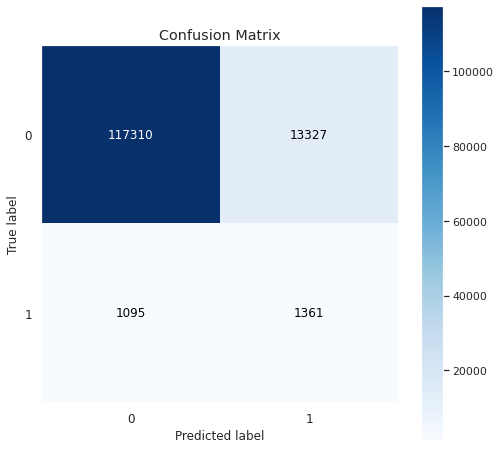

In [163]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_sgb, normalize = False, figsize = (8,8))

## 7.4.1. Cross Validation SGB

In [164]:
#cross validation scores
#sgb_cv = cross_val_score(sgb,X_train, y_train.ravel(), cv = 10, n_jobs = -1)
#pickle.dump(sgb_cv, open('/content/drive/My Drive/syn_finan/fraud_detect/models/sgb_cv.pkl', 'wb'))
sgb_cv = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/models/sgb_cv.pkl', 'rb'))

In [165]:
#mean and standard deviation
sgb_true = "Average SGB: {} +/- Std {}".format(np.round(np.mean(sgb_cv),4),np.round(np.std(sgb_cv),6))

## 7.5. Machine Learning Performance

In [166]:
#concat each performance as a dataframe
performance = pd.concat([result_rf,result_lgbm,result_sgb])
performance.sort_values('Precision_score', ascending = False)

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Random Forest Classifier,0.99634,0.89048,0.82166,0.89233,0.97629
0,LGBM Classifier,0.99729,0.92389,0.91002,0.92527,0.94105
0,Stochastic Gradient Descent,0.89164,0.13131,0.55415,0.15877,0.09266


## 7.5.1. Cross Validation Performance

In [167]:
print(lgbm_true)
print(rf_true)
print(sgb_true)

Average LGBM: 0.9959 +/- Std 0.001725
Average RF: 0.9966 +/- Std 0.000331
Average SGB: 0.9788 +/- Std 0.027951


# 8.0. Step 08 - Hyperparameter Fine Tuning

## 8.1. Random Search

In [171]:
#define model
rf_tuned = RandomForestClassifier(n_jobs = -1, random_state = 42)

#parameters
param =  {'max_depth': np.arange(2, 12, 2), 
         'n_estimators': np.arange(45, 155, 60)}

#define random search cv
rf_tuned_cv = RandomizedSearchCV(estimator=rf_tuned, param_distributions=param,
                                scoring='accuracy', n_iter=100, cv=10, verbose=2,
                                random_state=42, n_jobs=-1)

#fit RandomSearchCV
rf_tuned_cv.fit(X_train, np.ravel(y_train))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.1min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [172]:
rf_tuned_cv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=105,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [173]:
pickle.dump(rf_tuned_cv, open('/content/drive/My Drive/syn_finan/fraud_detect/models/rf_tuned_cv.pkl', 'wb'))

## 8.2. Tuned Model

In [175]:
#define model
rf_tuned = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=105,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#training model
rf_tuned.fit(X_train, y_train)
pickle.dump(rf_tuned, open('/content/drive/My Drive/syn_finan/fraud_detect/models/rf_tuned.pkl', 'wb'))
#rf = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/models/rf.pkl', 'rb'))

#predict model
yhat_rf_tuned = rf_tuned.predict(X_test)
pickle.dump(yhat_rf_tuned, open('/content/drive/My Drive/syn_finan/fraud_detect/models/yhat_rf_tuned.pkl', 'wb'))
#yhat_rf = pickle.load(open('/content/drive/My Drive/syn_finan/fraud_detect/models/yhat_rf.pkl', 'rb'))

#performance
result_rf_tuned = pd.DataFrame(["Random Forest Classifier Tuned",accuracy_score(y_test,yhat_rf_tuned),cohen_kappa_score(y_test,yhat_rf_tuned),
                          recall_score(y_test,yhat_rf_tuned), f1_score(y_test,yhat_rf_tuned),
                           precision_score(y_test,yhat_rf_tuned)]).T
result_rf_tuned.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_rf_tuned))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    130637
           1       0.99      0.73      0.84      2456

    accuracy                           0.99    133093
   macro avg       0.99      0.86      0.92    133093
weighted avg       0.99      0.99      0.99    133093



In [183]:
result_rf_tuned

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Random Forest Classifier Tuned,0.99485,0.83654,0.72720,0.83909,0.99167


## 8.3. Fine Tuning RF Cross Validation

In [179]:
#cross validation scores
rf_tuned_cv = cross_val_score(rf_tuned,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(rf_tuned_cv),4),np.round(np.std(rf_tuned_cv_final),4)))

NameError: ignored

In [181]:
print("Average: {} +/- Std {}".format(np.round(np.mean(rf_tuned_cv),4),np.round(np.std(rf_tuned_cv),4)))

Average: 0.9952 +/- Std 0.0004
